<h2 id="tocHeading">Youtube Trending Video Analysis</h2>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Summary
The main goal of the analysis is to find interesting facts and patterns by exploring the data and by using effective visualizations.

## Data Source
The data used in this analysis was downloaded from [Kaggle](https://www.kaggle.com/datasnaek/youtube-new) which was actually fetched from YouTube APIs.

This dataset includes several months (and counting) of data on daily trending YouTube videos. Data is included for the US, GB, DE, CA, FR, RU, MX, KR, JP, and IN regions (USA, Great Britain, Germany, Canada, France, Russia, Mexico, South Korea, Japan, and India respectively), with up to 200 listed trending videos per day.

Each region’s data is in a separate file. Data includes the video title, channel title, publish time, tags, views, likes and dislikes, description, and comment count.

The data also includes a category_id field, which varies between regions. To retrieve the categories for a specific video, find it in the associated JSON. One such file is included for each of the five regions in the dataset.

For more information on specific columns in the dataset refer to the [column metadata](https://www.kaggle.com/datasnaek/youtube-new/data).

## Data loading and preparation


### Import packages and libraries

In [2]:
import pandas as pd
import glob
import json
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns

### Read the dataset

#### Fetch & Read all the data files (.csv)

In [3]:
# Get the CSV (or data files) location
path="C:/Users/VershaDeota/Data Science/archive/"

In [4]:
# Read all the (csv) files and merge to a single dataframe
all_files=glob.glob(os.path.join(path, "*.csv"))
all_df = []
for f in all_files:
    df = pd.read_csv(f, sep=',',encoding='latin1')
    #print((f.split('videos.csv')[0][::-1])[0:2][::-1])        
    df['country'] = (f.split('videos.csv')[0][::-1])[0:2][::-1]
    all_df.append(df)
    
merged_df = pd.concat(all_df, ignore_index=True)

#### Fetch & Read the json files for retrieving category details

In [6]:
category_id = {}

# Read the US Category file 
with open(os.path.join(path, "US_category_id.json"), 'r') as f:
    data = json.load(f)
    for category in data['items']:
        category_id[category['id']] = category['snippet']['title']

In [7]:
# Create a new column in the dataframe and add the category name after mapping it with exisitng category_id in the dataframe
merged_df['category_id']=merged_df['category_id'].astype(str)
merged_df.insert(4, 'category', merged_df['category_id'].map(category_id))

### Clean, format and pre-process the dataset

#### Handle Null and N/A values

In [8]:
# Find and remove missing and null values
merged_df.isna().sum()

video_id                      0
trending_date                 0
title                         0
channel_title                 0
category                      0
category_id                   0
publish_time                  0
tags                          0
views                         0
likes                         0
dislikes                      0
comment_count                 0
thumbnail_link                0
comments_disabled             0
ratings_disabled              0
video_error_or_removed        0
description               19478
country                       0
dtype: int64

In [9]:
# As we see above that the 'description' columns has a lot of null/na values, let's go ahead and remove them from the dataframe
merged_df["description"] = merged_df["description"].fillna(value="")
#merged_df.isna().sum()

#### Format 'Date' Columns for better handling

In [14]:
merged_df['trending_date'] = pd.to_datetime(merged_df['trending_date'], format='%y.%d.%m')
#merged_df['trending_date'].head()
merged_df['publish_time'] = pd.to_datetime(merged_df['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')
#merged_df['publish_time'].head()

0   2017-11-10 17:00:03
1   2017-11-13 17:00:00
2   2017-11-12 19:05:24
3   2017-11-12 18:01:41
4   2017-11-09 11:04:14
Name: publish_time, dtype: datetime64[ns]

In [16]:
# separates date and time into two columns from 'publish_time' column
merged_df.insert(4, 'publish_date', merged_df['publish_time'].dt.date)
merged_df['publish_time'] = merged_df['publish_time'].dt.time
merged_df[['publish_date', 'publish_time']].head()

,publish_date,publish_time
0,2017-11-10,17:00:03
1,2017-11-13,17:00:00
2,2017-11-12,19:05:24
3,2017-11-12,18:01:41
4,2017-11-09,11:04:14


## Analysis & Visualization
Now let’s start with the process of analysing the data and look at the various results the data can provide us with.

### Which is the most trending category for youtube videos across all countries?

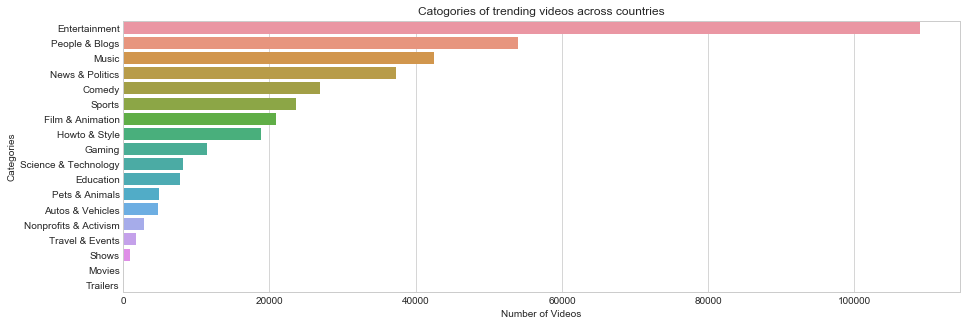

In [27]:
category_df_all = merged_df['category'].value_counts().reset_index()
plt.figure(figsize=(15,5))
ax = sns.barplot(y=category_df_all['index'],x=category_df_all['category'], data=category_df_all,orient='h')
ax.set(xlabel="Number of Videos", ylabel = "Categories", title="Catogories of trending videos across countries");

In [28]:
category_df_top3=pd.DataFrame(merged_df.groupby(['country','category'])['category'].agg(['count'])).sort_values('count',ascending=False).groupby('country').head(3).reset_index()

category_df_top3=category_df_top3.sort_values(['country','count'],ascending=False).reset_index()
category_df_top3.drop(['index'], axis=1,inplace=True)
category_df_top3

,country,category,count
0,US,Entertainment,9964
1,US,Music,6472
2,US,Howto & Style,4146
3,RU,People & Blogs,10350
4,RU,Entertainment,5943
5,RU,News & Politics,5402
6,MX,Entertainment,13487
7,MX,People & Blogs,8159
8,MX,Sports,4050
9,KR,Entertainment,8955


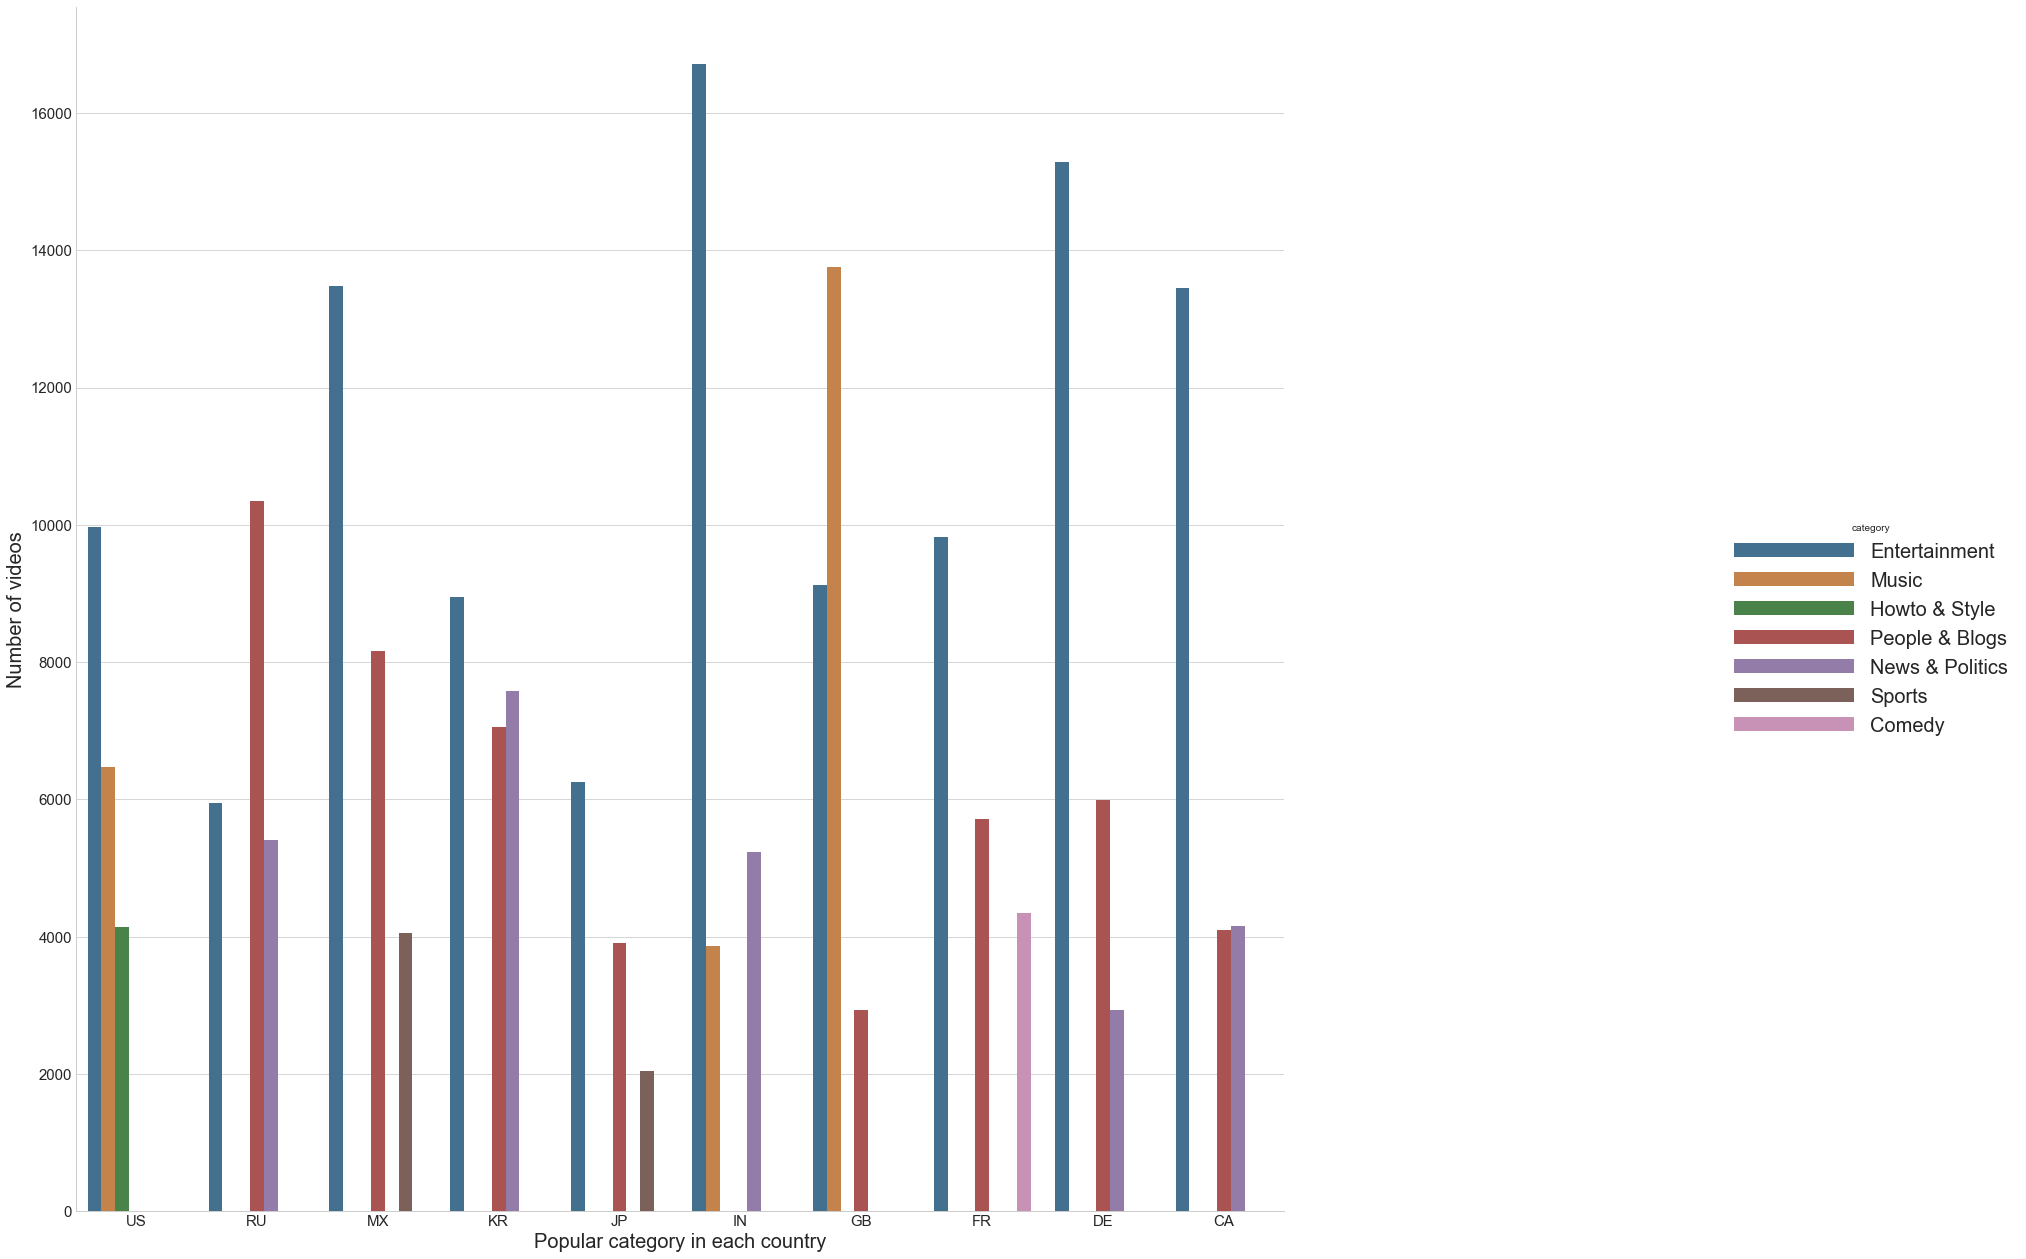

In [47]:
g=sns.factorplot(x="country", y="count",data=category_df_top3, hue="category", saturation=.5, ci=None,kind='bar',aspect=2); 
g.fig.set_size_inches(30, 20)
g.set_xticklabels(fontsize= 15)
g.set_yticklabels(fontsize= 15)
g.set_xlabels('Popular category in each country', fontsize= 20)
g.set_ylabels('Number of videos', fontsize= 20)
params = {'legend.fontsize': 20,
          'legend.handlelength': 6}
plt.rcParams.update(params);

#### Insights
**The Trending Category** across all countries is _**Entertainment**_, which leads way ahead in the total number of views crossing the _**100K**_ mark. The second most trending category is _**People & Blogs**_ with total views reaching around _**50K**_ mark.

If we further drill down to find out how the trend looks for each country, we find that _**Entertainment**_ is the top trending category in all the countries except for _**Russia**_ and _**Great Britain**_ (where _**Entertainment**_ is the _**2nd**_ most trending category).

### How long does it take for a video to become trending in countries like Germany and France?

#### What does Germany's data say?
Let's calculate the date difference between the video publish and trending date.

_**Consideration**:The videos can be trending for more than one day, and thus to get the correct analysis done, we should always consider the date when the video started trending first_.

In [48]:
# Get the Trending Date and Publish Date for the all the videos and calculate the difference between them
df_de=pd.DataFrame(merged_df[merged_df['country']=='DE'].groupby('video_id')[['publish_date','trending_date']].agg(['min'])).reset_index()
df_de.columns = df_de.columns.droplevel(-1)
df_de['days_diff']=(pd.to_datetime(df_de['trending_date']).dt.date-pd.to_datetime(df_de['publish_date']).dt.date).dt.days
df_de.head()

,video_id,publish_date,trending_date,days_diff
0,--7vNbh4UNA,2018-04-13,2018-04-14,1
1,--I0aj8MUdU,2018-02-04,2018-02-05,1
2,--MtKsH5oBY,2018-05-31,2018-05-31,0
3,--moh3hSPpY,2018-01-02,2018-01-03,1
4,--rE6D0_jAw,2018-04-29,2018-04-30,1


In [49]:
# Find the average of the date difference (between publish_date & trending_date)
df_de['days_diff'].mean()

1.5701893543051946

##### Insights
From the above analyis we can see that it takes on an average _**less than a couple of days**_ for a video to become trending in _**Germany**_.

#### What does France's data say?
Let's calculate the date difference between the video publish and trending date.

_**Consideration**:The videos can be trending for more than one day, and thus to get the correct analysis done, we should always consider the date when the video started trending first_.

In [50]:
df_fr=pd.DataFrame(merged_df[merged_df['country']=='FR'].groupby('video_id')[['publish_date','trending_date']].agg(['min'])).reset_index()
df_fr.columns = df_fr.columns.droplevel(-1)
df_fr['days_diff']=(pd.to_datetime(df_fr['trending_date']).dt.date-pd.to_datetime(df_fr['publish_date']).dt.date).dt.days
df_fr.head()

,video_id,publish_date,trending_date,days_diff
0,--2K8l6BWfw,2018-03-05,2018-03-06,1
1,--728h8mnDY,2017-12-05,2017-12-06,1
2,--8-sr76Haw,2018-05-08,2018-05-09,1
3,--DqT_lWyEU,2018-06-04,2018-06-05,1
4,--FcOKEq9gU,2018-03-31,2018-04-01,1


In [51]:
# Find the average of the date difference (between publish_date & trending_date)
df_fr['days_diff'].mean()

2.8108956541643506

##### Insights
From the above analyis we can see that it takes on an average around _**3 days**_ for a video to become trending in _**France**_.

### List the Top 10 channels across all countries, that had at least 3 trending videos

In [61]:
# For further analysis we will work with smaller dataset. 
# Sort all the videos by views and remove duplicate records based on video_id
# The final dataset will give us the unique videos with trending_date as the last day when the video was trending
df_subset=merged_df.sort_values(by='views', ascending=False).drop_duplicates(subset=['video_id']) 

In [62]:
df_channel=pd.DataFrame(df_subset.groupby('channel_title')['video_id'].nunique()).reset_index()

In [63]:
df_channel.rename(columns={'video_id':'video_count'}, inplace=True)

In [65]:
# Get the channels which has more than 3 trending videos
df_channel_top10_video_count=df_channel[df_channel['video_count']>=3]

# List the Top 10 Channels 
df_channel_top10_video_count.nlargest(10,'video_count')

,channel_title,video_count
20903,SET India,253
20803,SAB TV,248
25720,VikatanTV,240
30489,ÐÐ½Ð°ÑÐ¾Ð»Ð¸Ð¹ Ð¨Ð°ÑÐ¸Ð¹,235
23982,The Late Show with Stephen Colbert,230
7300,Elhiwar Ettounsi,212
26004,WWE,203
32375,Ð Ð¾ÑÑÐ¸Ñ 24,194
6937,ESPN,185
3968,CNN,179


#### Insights
The table above shows the Top 10 Channels across all countries. It can be seen that _**SET India**_ is the most popular channel across all countries and has the maximum number of views for the videos uploaded in that channel. This is followed by _**SAB TV**_ & _**VikatanTV**_. If we look at the category of these channels, these belong to _Entertainment_ category.

 ### What are the Likes/Views and Dislikes/Views for the Top 10 Channels across all countries?

In [82]:
lst=df_subset.groupby('channel_title')['video_id'].nunique().nlargest(10).index.tolist()
df_channel_top10=df_subset[df_subset['channel_title'].isin(lst)]

#### Likes/Views

In [84]:
view_like_ratio=df_channel_top10.groupby('channel_title').apply(lambda s: s.likes.sum()/s.views.sum()).sort_values(ascending=False).reset_index()
view_like_ratio.columns = ['channel','ratio']
view_like_ratio

,channel,ratio
0,ÐÐ½Ð°ÑÐ¾Ð»Ð¸Ð¹ Ð¨Ð°ÑÐ¸Ð¹,0.068208
1,WWE,0.016863
2,The Late Show with Stephen Colbert,0.013203
3,CNN,0.009727
4,ESPN,0.008659
5,SET India,0.007929
6,Ð Ð¾ÑÑÐ¸Ñ 24,0.007845
7,SAB TV,0.005612
8,VikatanTV,0.005433
9,Elhiwar Ettounsi,0.005144


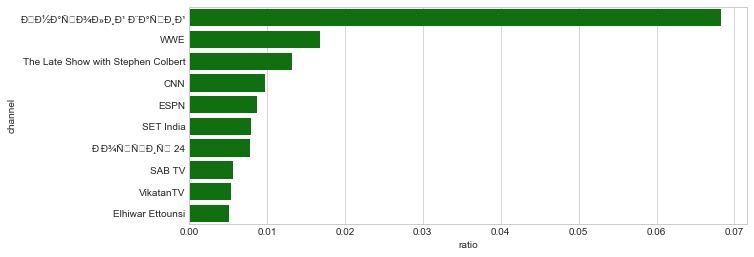

In [85]:
plt.subplots(figsize=(10, 4))
sns.barplot(x="ratio", y="channel", data=view_like_ratio,
            label="Views-Likes Ratio", color="g");

##### Insights
From the above analysis, we could find that the channel _**ÐÐ½Ð°ÑÐ¾Ð»Ð¸Ð¹ Ð¨Ð°ÑÐ¸Ð¹**_, has the maximum Likes/Views ratio. This means that the videos in this channel are viewed a lot and at the same time liked as well and making it to the _**#4**_ in the Top 10 Channel list.

#### Dislikes/Views

In [86]:
view_dislike_ratio=df_channel_top10.groupby('channel_title').apply(lambda s: s.dislikes.sum()/s.views.sum()).sort_values(ascending=False).reset_index()
view_dislike_ratio.columns = ['channel','ratio']
view_dislike_ratio

,channel,ratio
0,Ð Ð¾ÑÑÐ¸Ñ 24,0.005315
1,CNN,0.003361
2,ÐÐ½Ð°ÑÐ¾Ð»Ð¸Ð¹ Ð¨Ð°ÑÐ¸Ð¹,0.002406
3,VikatanTV,0.001752
4,ESPN,0.001097
5,Elhiwar Ettounsi,0.000935
6,WWE,0.000909
7,SET India,0.000888
8,The Late Show with Stephen Colbert,0.000813
9,SAB TV,0.000803


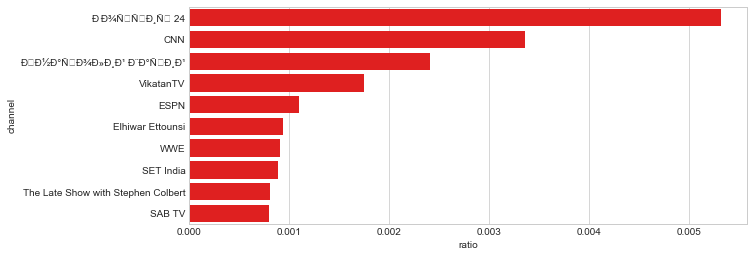

In [88]:
plt.subplots(figsize=(10, 4))
sns.barplot(x="ratio", y="channel", data=view_dislike_ratio,
            label="Views-Likes Ratio", color="r");

##### Insights
From the above analysis, we could find that the the channel _**Ð Ð¾ÑÑÐ¸Ñ 24**_, has the maximum Dislikes/Views ratio. This means that even though the videos in this channel are viewed a lot, people don't like the content. But, still based on the all factors the channel is part of the Top 10 Channel list at _**#8**_.

### How many unique Twitter profiles were listed in the description of the videos per country?

In [89]:
# Creating an empty dataframe to record unique url by country
tweet_df = pd.DataFrame(columns=['country','twitter_url'])

In [90]:
# e.g.	Tweet Profile URL example “https://twitter.com/eminem”
# Use RegularExpression to find the URL from description and store that in the dataframe created above

for i,row in df.iterrows():
    reg_row=re.findall(r'(https?://twitter\.com\/[a-zA-Z0-9_]+ )', row['description'])
    for j in reg_row:
        tweet_df.loc[len(tweet_df)]=[row['country'],j]
        

In [91]:
## Group the urls found above by country
unique_tweet_url=pd.DataFrame(tweet_df.groupby('country')['twitter_url'].nunique()).reset_index()
unique_tweet_url=unique_tweet_url.sort_values(by='twitter_url', ascending=False)
unique_tweet_url

,country,twitter_url
0,CA,2114
2,FR,2011
7,MX,1968
5,JP,1561
1,DE,1328
9,US,1070
3,GB,881
8,RU,787
4,IN,688
6,KR,264


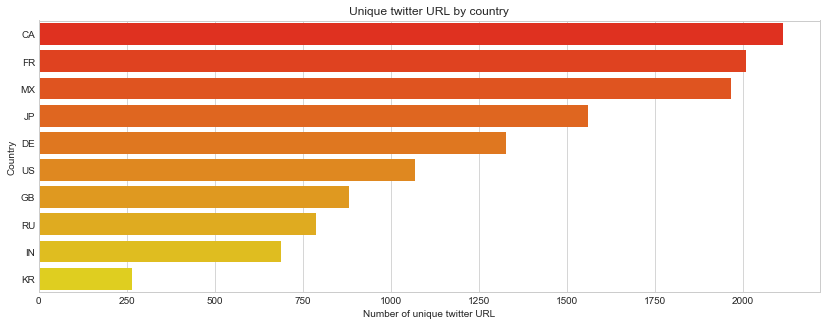

In [92]:
# Visualize
fig, ax = plt.subplots(figsize=(14,5))
ax = sns.barplot(y=unique_tweet_url['country'],x=unique_tweet_url['twitter_url'], data=unique_tweet_url,orient='h',
                palette=(sns.color_palette('autumn', n_colors=10)[:]),
                dodge=False)
plt.xlabel("Number of unique twitter URL")
plt.ylabel("Country")
plt.title("Unique twitter URL by country");

#### Insights
_**Canada**_ leads in the number of unique Twitter profiles listed in the video's description, followed by _**France**_ and _**Mexico**_.